# Tutorial: Entendimiendo de los datos

Continuando con el proyecto de consultoria de Wide World Importers, el primer paso para iniciar la comprensión de los datos es explorar y entender las fuentes de datos disponibles. Note que esto también nos ayuda a comprender mejor la organización.

## Configuración e importe de paquetes
Se utilizará el paquete de pandas profiling para apoyar el análisis estadístico, y se importan los paquetes de python
necesarios

In [1]:
import pyspark
from pyspark.sql import SparkSession 
from pyspark.sql import functions
from pyspark.sql.types import StructType
from pyspark import SparkContext, SparkConf, SQLContext
from pyspark.sql.types import FloatType, StringType, IntegerType, DateType
from pyspark.sql.functions import udf, col, length, isnan, when, count
import pyspark.sql.functions as f
import os 
from datetime import datetime
from pyspark.sql import types as t
from pandas_profiling import ProfileReport
#import matplotlib.pyplot as plt
import numpy as np

C:\Users\estudiante\anaconda3\envs\Tutoriales\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Configuración del controlador e inicio de sesion Spark

In [2]:
path_jar_driver = 'C:\Program Files (x86)\MySQL\Connector J 8.0\mysql-connector-java-8.0.28.jar'

In [3]:
#Configuración de la sesión
conf=SparkConf() \
    .set('spark.driver.extraClassPath', path_jar_driver)

spark_context = SparkContext(conf=conf)
sql_context = SQLContext(spark_context)
spark = sql_context.sparkSession

C:\Users\estudiante\anaconda3\envs\Tutoriales\lib\site-packages\pyspark\sql\context.py:79: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


In [4]:
# Si quiere practicar la conexion con el servidor de base de datos:
db_connection_string = 'jdbc:mysql://157.253.236.116:8080/WWImportersTransactional'
# El usuario es su estudiante _i asignado y su contraseña la encontrará en el archivo excel de Coursera 
db_user = 'Estudiante_22'
db_psswd = 'PTJIBT5R5E'

PATH='./'

### Información dada por la organización relacionada con los datos

En esta actividad le recomendamos revisar el diccionario de datos suministrado y en particular la información relacionada con esta tabla. Si tienen alguna duda relacionada a esta tabla deben incluirla en las preguntas o aclaraciones que le entreguen al negocio. En relación a los datos Wide World Importers menciona:

- La cantidad máxima de productos movidos es 50 millones por viaje
- Existen 236.668 movimientos de producto realizados desde 2013
- Los movimientos están relacionados con 228.265 clientes
- El formato de fechas manejado es YYYY-MM-DD HH:MM:SS
- Actualmente tenemos 13 proveedores

Idealmente debe terminar con una lista de preguntas o aclaraciones para la organización, conclusiones de los datos/problemas de calidad y alternativas para la limpieza.

### Conexión a fuente de datos y acceso a los datos

#### Conexión a fuente de datos
A continuación encuentra las funciones para conectarse a la fuente de datos (archivo csv o base de datos) y retornar un dataframe que es el que se utilizará posteriormente para manipular los datos.

In [5]:
def obtener_dataframe_de_bd(db_connection_string, sql, db_user, db_psswd):
    df_bd = spark.read.format('jdbc')\
        .option('url', db_connection_string) \
        .option('dbtable', sql) \
        .option('user', db_user) \
        .option('password', db_psswd) \
        .option('driver', 'com.mysql.cj.jdbc.Driver') \
        .load()
    return df_bd

#### Cargue de datos
Los criterios generales para la evaluación de la actividad son:
1. Completitud del perfilamiento de datos (40 puntos)
- Cantidad de registros y cantidad de columnas por tipo de dato 
- Significado de una fila 
- Estadísticas descriptivas por columna (numérica, categórica, fechas) 


In [6]:
sql_movimientoscopia = '''(SELECT mc.TransaccionProductoID,
mc.ProductoID, NombreProducto,
tt.TipoTransaccionID, tt.TipoTransaccionNombre, 
mc.ClienteID,
mc.InvoiceID,
mc.ProveedorID, pc.NombreProveedor,
mc.OrdenDeCompraID,
mc.FechaTransaccion,
mc.Cantidad 
FROM movimientosCopia mc
INNER JOIN TiposTransaccion tt ON tt.TipoTransaccionID=mc.TipoTransaccionID
INNER JOIN Producto pr ON pr.ID_Producto=mc.ProductoID 
INNER JOIN provedoresCopia pc ON pc.ProveedorID=mc.ProveedorID
order by Cantidad desc) AS Compatible'''

In [65]:
sql_producto = '''(SELECT ID_Producto, NombreProducto, Marca, ID_Color, Necesita_refrigeracion, Dias_tiempo_entrega, Impuesto, PrecioUnitario, PrecioRecomendado 
FROM Producto) AS Productos'''

In [98]:
sql_proveedor = '''(SELECT 
ProveedorID, 
NombreProveedor, 
CategoriaProveedorID, 
PersonaContactoPrincipalID, 
PersonaContactoAlternoID, 
MetodoEntregaID, 
CiudadEntregaID,
CiudadID,
ReferenciaProveedor,
NombreCuentaBanco,
MarcaCuentaBanco,
CodigoCuentaBanco,
NumeroCuentaBaco,
CodigoInternacionalBanco,
DiasPago,
ComentariosInternos,
NumeroTelefono,
NumeroFax,
URL,
Direccion1,
Direccion2,
CodigoPostal,
UbicacionEntrega,
DireccionPostal1,
DireccionPostal2,
CodigoPostal2,
UltimaEdicionPor
FROM provedoresCopia order by ProveedorID asc) AS Proveedor'''

Para ver la cantidad de registros, se utilizo el comando <i>Count</i> ingresando el identificador de la tabla TransaccionProductoID, de la tabla a consultar.

In [99]:
sql_cantidadregistros = '''(SELECT  COUNT(mc.TransaccionProductoID) AS CATIDAD
from movimientosCopia mc ) AS CATIDAD'''

In [100]:
#Se cargan los dataframes desde la base de datos
movimientoscopia  = obtener_dataframe_de_bd(db_connection_string, sql_movimientoscopia, db_user, db_psswd)
producto = obtener_dataframe_de_bd(db_connection_string, sql_producto, db_user, db_psswd)
proveedor = obtener_dataframe_de_bd(db_connection_string, sql_proveedor, db_user, db_psswd)
cantidadregistros = obtener_dataframe_de_bd(db_connection_string, sql_cantidadregistros, db_user, db_psswd)

### Entendimiento general de datos

Para ver una muestra de los datos, utilice el comando <i>show</i> ingresando el número de filas que quiere ver

In [12]:
movimientoscopia.show(5)

+---------------------+----------+--------------------+-----------------+---------------------+---------+---------+-----------+---------------+---------------+----------------+--------+
|TransaccionProductoID|ProductoID|      NombreProducto|TipoTransaccionID|TipoTransaccionNombre|ClienteID|InvoiceID|ProveedorID|NombreProveedor|OrdenDeCompraID|FechaTransaccion|Cantidad|
+---------------------+----------+--------------------+-----------------+---------------------+---------+---------+-----------+---------------+---------------+----------------+--------+
|               335504|       193|Black and orange ...|               11|        Stock Receipt|      0.0|      0.0|        7.0|   Litware Inc.|         2069.0|     May 30,2016| 67368.0|
|               335845|       193|Black and orange ...|               11|        Stock Receipt|      0.0|      0.0|        7.0|   Litware Inc.|         2072.0|     May 31,2016| 67272.0|
|               334872|       193|Black and orange ...|               

### Entendimiento general de datos

<i>Significado de una fila </i>.

Como puede observar en la tabla de movimientosCopia se tiene informacion **relacionada con el producto, el tipo de transaccion, el proveedor, el cliente, el identificador de la factura, con la órden, fecha del movimiento en inventario y la cantidad de productos que se retiraron/ingresaron a inventario**. 

- La información del producto su identificador <i>ProductoID</i>, el cual representa el producto que fue extraido o agregado en el inventario.
- La información del tipo de transaccion <i>TipoTransaccionID</i>, el cual representa el tipo de transaccion del movimiento.
- La información del Cliente <i>ClienteID</i>, representa el cliente que hace la compra.
- La información de la factura <i>InvoiceID</i>, representa el Identificador de la factura.
- La información del Proveedor <i>ProveedorID</i>, representa el proveedor del producto en movimiento.
- La información de la orden <i>OrdenDeCompraID</i>, representa el id de la orden de este movimiento.
- La información de la fecha del movimiento <i>FechaTransaccion</i>, representa la fecha del movimiento en inventario.
- La información de la cantidad de productos <i>Cantidad</i>, representa la cantidad de productos que se retiraron/ingresaron a inventario.


<i>Estadísticas descriptivas por columna (numérica, categórica, fechas)</i> ingresando el número de filas que se quiere ver

In [10]:
movimientoscopia.schema

StructType(List(StructField(TransaccionProductoID,IntegerType,true),StructField(ProductoID,IntegerType,true),StructField(NombreProducto,StringType,true),StructField(TipoTransaccionID,IntegerType,true),StructField(TipoTransaccionNombre,StringType,true),StructField(ClienteID,DoubleType,true),StructField(InvoiceID,DoubleType,true),StructField(ProveedorID,StringType,true),StructField(NombreProveedor,StringType,true),StructField(OrdenDeCompraID,StringType,true),StructField(FechaTransaccion,StringType,true),StructField(Cantidad,DoubleType,true)))

<i>El esquema del DataFrame incluye los nombres de las columnas asi como el tipo de dato.</i>.

Tambien podemos saber la cantidad de datos disponibles, esto se hace con count() y con columns, que retornan el número de filas y número de columnas respectivamente.

In [13]:
print(movimientoscopia.count(), len(movimientoscopia.columns))

7110 12


**¿Cuantos datos nos compartieron para el proyecto?**
En total tenemos 7110 movimientos y tenemos en total 12 variables a revisar de las cuales 3 son nùmericas asociadas a las movimientos, no existe campos son de tipo fecha y las demás son cadenas de caracteres.

### Revisión de reglas de negocio 

Primero se confirman las reglas proporcionadas por el negocio, que son las siguientes:
- La cantidad máxima de productos movidos es 50 millones por viaje
- Existen 236.668 movimientos de producto realizados desde 2013
- Los movimientos están relacionados con 228.265 clientes
- El formato de fechas manejado es YYYY-MM-DD HH:MM:SS
- Actualmente tenemos 13 proveedores

La siguiente regla nos indica **El formato de fechas manejado es YYYY-MM-DD HH:MM:SS**, un ejemplo es el atributo <i>FechaTransaccion</i>. Para esto vamos a hacer uso de expresiones regulares, que son patrones de búsqueda, en este caso queremos 4 dígitos entre 0 y 9 que indican el año seguido del símbolo - luego tenemos un número de 2 dígitos que puede empezar con 0 seguido de un número entre 1 y 9 (meses 01 hasta 09) o 1 seguido de 1 o 2 (meses 11 o 12), sigue otro -, y terminamos con un número de 2 dígitos que van desde el día 01 hasta el 31, se usa rlike smilar a LIKE de SQL

In [16]:
regex = "[0-2]\d{3}-(0[1-9]|1[0-2])-(0[1-9]|[1-2][0-9]|3[0-1])"
cumplenFormato = movimientoscopia.filter(movimientoscopia["FechaTransaccion"].rlike(regex))
print("Número total de movimientos: "+str(movimientoscopia.count())+", número de ordenes con formato correcto: "+
      str(cumplenFormato.count()))

Número total de movimientos: 7110, número de ordenes con formato correcto: 4880


Para ver los registros que no cumplen con el formato podemos negar la condición del filtro con el símbolo ~ al principio:

In [17]:
noCumplenFormato = movimientoscopia.filter(~movimientoscopia["FechaTransaccion"].rlike(regex))
noCumplenFormato.count(), noCumplenFormato.select(col("FechaTransaccion")).show()

+----------------+
|FechaTransaccion|
+----------------+
|     May 30,2016|
|     May 31,2016|
|     May 27,2016|
|     May 26,2016|
|     May 24,2016|
|     May 23,2016|
|     May 19,2016|
|     May 16,2016|
|     May 17,2016|
|     May 11,2016|
|     May 09,2016|
|     May 12,2016|
|     Apr 29,2016|
|     Apr 27,2016|
|     Apr 26,2016|
|     Apr 13,2016|
|     Apr 14,2016|
|     Apr 18,2016|
|     Apr 20,2016|
|     Apr 07,2016|
+----------------+
only showing top 20 rows



(2230, None)

Se concluye entonces, que hay 2.230 registros cuya fecha no cumple con el formato especificado. Sin embargo, los valores que son diferentes parecen serlo solo porque varia el formato, este tipo de casos pueden ser solucionados fácilmente por lo que una notificación al negocio sería con caracter informativo más que para solicitar una aclaración de su parte.

Para facilitar los análisis y evitar inconsistencias o conclusiones erradas vamos a estandarizar los datos, en este caso las fechas. Sin embargo, esta actividad puede hacerse sobre formatos de números, texto entre otras. 

Algo que se debe tener en cuenta en el perfilamiento de reglas de negocio es que dichas reglas pueden estar incompletas, por ende se recomienda tener especial cuidado con las columnas **ProveedorID, OrdenDeCompraID** dado que suelen ser pasadas por alto en el análisis estadistico, al ser una columna de tipo text, deberia tener relacion con la tabla respectiva. Sin embargo haciendo la validación vemos que alguno de estos campos son textos incompletos o sin dato. Este podría llegar a ser un problema a futuro por lo que se decide notificar a la organización.

In [39]:
movimientoscopia.where(length(col("ProveedorID")) <= 10).show()

+---------------------+----------+--------------------+-----------------+---------------------+---------+---------+-----------+---------------+---------------+--------------------+--------+
|TransaccionProductoID|ProductoID|      NombreProducto|TipoTransaccionID|TipoTransaccionNombre|ClienteID|InvoiceID|ProveedorID|NombreProveedor|OrdenDeCompraID|    FechaTransaccion|Cantidad|
+---------------------+----------+--------------------+-----------------+---------------------+---------+---------+-----------+---------------+---------------+--------------------+--------+
|               335504|       193|Black and orange ...|               11|        Stock Receipt|      0.0|      0.0|        7.0|   Litware Inc.|         2069.0|         May 30,2016| 67368.0|
|               335845|       193|Black and orange ...|               11|        Stock Receipt|      0.0|      0.0|        7.0|   Litware Inc.|         2072.0|         May 31,2016| 67272.0|
|               334872|       193|Black and orange

Dentro de las reglas de negocio de especifica que los movimientos están relacionados con 228.265 clientes

In [109]:
print(movimientoscopia.groupBy("ClienteID").count())

DataFrame[ClienteID: double, count: bigint]


Dentro de las reglas de negocio de especifica que se tienen 13 proveedores, pero se puede evidenciar que existe un total de 19 proveedores

In [101]:
print(proveedor.count(), len(proveedor.columns))

19 27


### Análisis descriptivo
Una vez cubierto lo básico de reglas de negocio, pasamos a perfilamiento estadístico. Para ver estadisticos generales como conteo, mínimo, máximo, desviación estandar y percentiles utilice summary()

In [ ]:
movimientoscopia.summary().show()

+-------+---------------------+------------------+--------------------+-----------------+---------------------+---------+---------+-----------------+-------------------+------------------+--------------------+------------------+
|summary|TransaccionProductoID|        ProductoID|      NombreProducto|TipoTransaccionID|TipoTransaccionNombre|ClienteID|InvoiceID|      ProveedorID|    NombreProveedor|   OrdenDeCompraID|    FechaTransaccion|          Cantidad|
+-------+---------------------+------------------+--------------------+-----------------+---------------------+---------+---------+-----------------+-------------------+------------------+--------------------+------------------+
|  count|                 7110|              7110|                7110|             7110|                 7110|     7110|     7110|             7110|               7110|              7110|                7110|              7110|
|   mean|    211952.4606188467|120.49071729957807|                null|             

En las estadísticas anteriores vemos que las columnas ClienteID, InvoiceID tienen un conteo igual a 0, es decir son columnas vacías por lo que se pueden eliminar.

Otras formas de observar distribución o estadísticos son las graficas, de barras, de dispersión, diagramas de caja, entre otros. Por ejemplo tenemos los siguientes diagramas de caja donde se observa claramente que tenemos un valor extremo en la variable cantidad (primer grafico) y donde podemos ver los valores extremos o bigotes que determinan el punto de separación entre valores atípicos y normales, los valores atipicos, los cuartiles entre otros

{'whiskers': [<matplotlib.lines.Line2D at 0x193047ffbc8>,
 'caps': [<matplotlib.lines.Line2D at 0x1930480eb08>,
 'boxes': [<matplotlib.lines.Line2D at 0x193047ffd48>],
 'medians': [<matplotlib.lines.Line2D at 0x193048136c8>],
 'fliers': [<matplotlib.lines.Line2D at 0x19304813cc8>],
 'means': []}

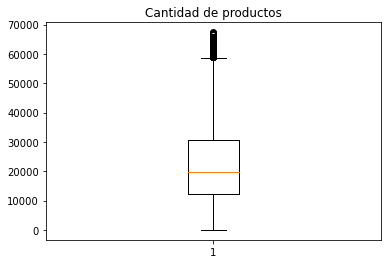

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

fig1, ax1 = plt.subplots()
ax1.set_title('Cantidad de productos')
ax1.boxplot(np.array(movimientoscopia.select('Cantidad').collect()))

El análisis anterior es muy útil para variables de tipo numérico, sin embargo es incompleto para las variables de tipo caracter o las variables categoricas, por ende es necesario implementar nuestro propio código par obtener estadisticos como la moda y la mediana. A continuación obtenemos la moda para la variable Descripcion:

In [ ]:
movimientoscopia.groupby("NombreProducto").count().orderBy("count", ascending=False).show(5)

+--------------------+-----+
|      NombreProducto|count|
+--------------------+-----+
|"The Gu" red shir...|  823|
|"The Gu" red shir...|  817|
|"The Gu" red shir...|  808|
|Tape dispenser (Red)|  805|
|Black and orange ...|  804|
+--------------------+-----+
only showing top 5 rows



## Análisis de calidad de datos
La calidad de los datos consiste en validar la idoneidad de los datos analizando varias dimensiones, entre las cuales resaltamos:
- Completitud: Datos que no existen o no se conocen
- Unicidad (Duplicidad): Datos que son idénticos en diferentes registros o registros con valores idénticos en atributos en los que no debería ocurrir
- Consistencia: Esta medida se define por la validez o integridad del dato, en la definición de su estructura, al interior de una fila o entre diferentes filas de la misma fuente o de diferentes fuentes. El manejo de unidades en los datos y el significado del dato son generadores de inconsistencias.
- Validez: a nivel de formato y de sentido de los datos más alla de sus valores

Para asegurar una calidad mínima de los datos en estas dimensiones hay que entender su origen y posteriormente realizar un proceso de validación de cada una de las dimensiones de perfilamiento que llevará a un entendimiento de los datos disponibles.


A continuación se definen dos funciones, la primera cuenta los valores vacios por columna de dataframe, la segunda retorna un diccionario de columnas con cardinalidad superior al 50%

Te invito a revisar los recursos de calidad de datos que hemos visto en el curso, a continuacion ejemplos daremos algunos ejemplos por cada dimensión para el caso del tutorial

### Unicidad y validez

La unicidad se revisó en la segunda regla de negocio y la validez se reviso en el perfilamiento general, en la regla de negocio 3 y en el análisis de la descripción al final de la sección de revisión de reglas de negocio

### Completitud y validez

In [58]:
def contar_vacios(df):
    resultados = []
    for c in df.columns:
        vacios = df.filter(df[c].isNull()).count()
        if vacios!=0:
            print('número de vacíos para columna '+c+': '+str( vacios ))
            resultados.append(vacios)
        if vacios!='':
            print('número de vacíos para columna '+c+': '+str( vacios ))
            resultados.append(vacios)
    return resultados

In [59]:
columnas_vacias_movimientos = contar_vacios(movimientoscopia)

número de vacíos para columna TransaccionProductoID: 0
número de vacíos para columna ProductoID: 0
número de vacíos para columna NombreProducto: 0
número de vacíos para columna TipoTransaccionID: 0
número de vacíos para columna TipoTransaccionNombre: 0
número de vacíos para columna ClienteID: 0
número de vacíos para columna InvoiceID: 0
número de vacíos para columna ProveedorID: 0
número de vacíos para columna NombreProveedor: 0
número de vacíos para columna OrdenDeCompraID: 0
número de vacíos para columna FechaTransaccion: 0
número de vacíos para columna Cantidad: 0


Como podemos observar para los movimientos las columnas tienen 0 campos vacios.

In [62]:
def cardinalidad(df):
    resultado = {}
    for c in df.columns:
        cardinalidad = df.select(col(c)).distinct().count()
        if cardinalidad>=df.count()*0.5:
            resultado[c] = cardinalidad
    return resultado

In [63]:
columnas_alta_cardinalidad_movimientos = cardinalidad(movimientoscopia)
columnas_alta_cardinalidad_movimientos

{'TransaccionProductoID': 6035}

Respecto a cardinalidad, solo la columna TransaccionProductoID tiene una cardinalidad superior al 50%.

### Consistencia
A nivel de consistencia algunos ejemplos de revisión son precios negativos, productos que aparecen en las ordenes pero que no esten registrados en la tabla de produtos. En nuestro caso vamos a verificar que todas las ordenes tengan detalle de orden y viceversa

In [68]:
#consistencia: revisar genially: definicion de consistencia
ids_movimientos = set([x.ProductoID for x in movimientoscopia.select('ProductoID').collect()])
ids_productos = set([x.ID_Producto for x in producto.select('ID_Producto').collect()])

len(ids_movimientos-ids_productos), len(ids_productos-ids_movimientos)

(0, 210)

Como se puede observar hay una diferencia de 0 movimientos que no tienen producto y hay  210 productos que no tienen movimiento. Ninguno de los casos tiene sentido en el contexto de WideWorldImporters. Esta inconsistencia se notifica al negocio dado que no hay forma de conocer cuáles son los registros que pueden tener ids que no existen

Como se puede observar hay una diferencia de la cantidd de registros que no tienen detalles se pueden observar en la consulta, ya que estos en la mayoria asocial el ID_cliente con un valor 0 y en clietes con ClienteID, no existe.

## Herramientas para facilitar el entendimiento de datos

Algunas de las estadísticas antes desarrolladas pueden obtenerse por medio de herramientas como Pandas Profiling una herramienta muy útil, <b><i>Pero no perfecta ni completa</i></b>, es Pandas profiling que dado un conjunto de datos, nos muestra histogramas, estadísticas etc. A continuación guardamos el reporte en html

In [69]:
reporte = ProfileReport(movimientoscopia.toPandas())
reporte.to_file(PATH+"reporte_prefilamiento.html")

Export report to file: 100%|██████████| 1/1 [00:00<00:00,  3.20it/s]


Lo primero que hay que notar es que hay 3 secciones principales. La primera es un resumen, la segunda es un análisis por cada variable y luego tenemos interacciones y correlaciones entre variables. 

Seccion general del reporte:
1. Tenemos 14 variables y 88.258 registros (es decir, ordenes), de las cuales 7 son numericas, 2 categoricas, 1 booleana, 1 datetime y 3 no soportadas (la herramienta entiende tipo de variable como tipo de dato, asi que la información que nos da no es necesariamente correcta en este aspecto).

2. En los datos hay 0.0%% de datos vacíos, (conclusión)

3. El archivo ocupa en memoria 583.4 KiB

4. Esiste un total de 1075, que equivale al 15.1% a regiatros duplicados.

Sección de variables del reporte:

5. Note que para cada variable nos dan estadisticos como la media, mínimo y máximo asi como un histograma de distribución de la variable, para nuestros datos no observamos nada por fuera de lo comun. (Como valores extremos)

6. La variable TransaccionProductoID tiene 84.9% valores distintos, es decir, es una variable con alta cardinalidad. Este tipo de variables no aportan a las relaciones entre filas o columnas, por lo que suelen no ser útiles a la hora de hacer análitica.

7. La variable ProductoID tiene solo el 0.2% de valores distintos, es decir que los movimientos tienen poca salida o entrada de productos, pero que la salida o entrada de estos productos son recurrentes.

8. Hay 3 proveedores en los datos de los movimientos

9. Hay 1256 Fecha de transaccion, siendo el 6 de abril del 2015 una de las fechas con más número de movimientos


### Algunas gráficas utiles: Diagrama de caja, dispersion, histogramas para entender las distribuciones de las variables

Generalmente las gráficas se emplean para entender la distribución de cada variable, también sirven para visualizar la relación entre 2 o más variables

Algunas gráficas útiles son los histogramas, disepersión, diagramas de caja. Hay varias maneras de implementarlos, con paquetes como matplotlib o pandas, con funciones propias de pyspark, etc, a continuacón mostramos cómo hacerlo a travez de pandas

array([[<AxesSubplot:title={'center':'Cantidad'}>]], dtype=object)

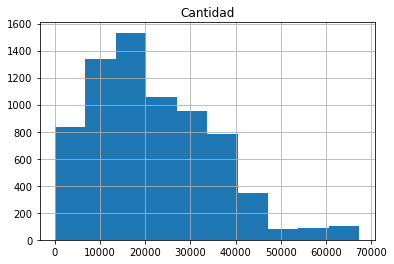

In [73]:
#para valores extremos(subir a calidad)
movimientoscopia.toPandas().hist(column='Cantidad')

In [87]:
cantproductos = movimientoscopia.groupby("ProductoID").count().orderBy("count", ascending=False)

Como se puede observar, el método retorna un dataframe, que vamos a usar para obtener dos arreglos, uno con el rango de cada una de las barras y otro con la cantidad de registros por rango. Se puede usar Matplotlib para graficar esta información:

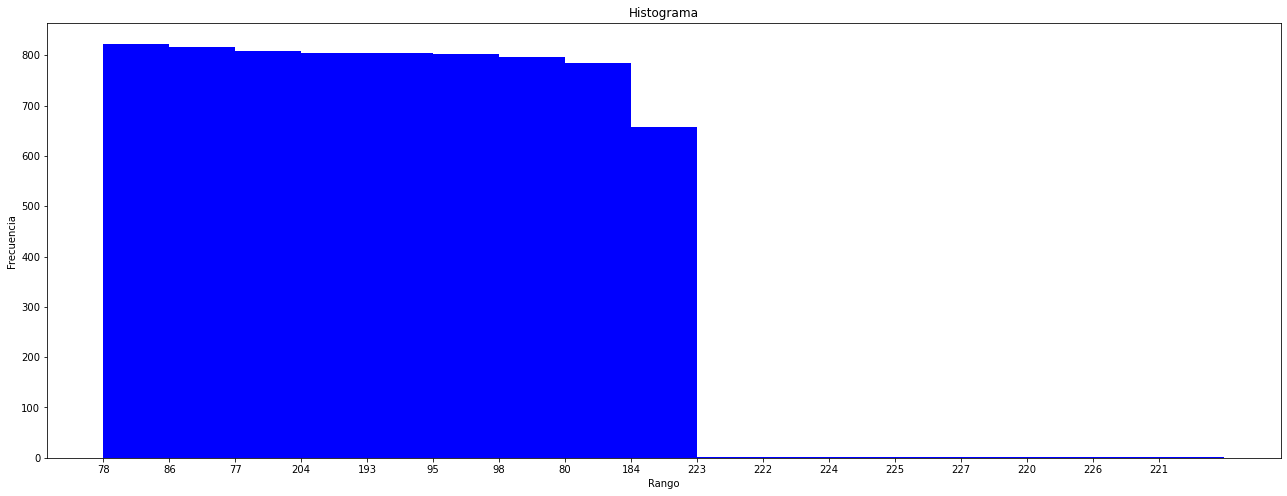

In [88]:
def plotHistogramData(data):
    binSides, binCounts = [row[0] for row in data.collect()], [row[1] for row in data.collect()]
    binSides = [round(i, 2) for i in binSides]
    N = len(binCounts)
    ind = np.arange(N)
    width = 1

    fig, ax = plt.subplots()
    rects1 = ax.bar(ind+0.5, binCounts, width, color='b')
    
    fig.set_size_inches(1.3*N, 8)

    ax.set_ylabel('Frecuencia')
    ax.set_xlabel('Rango')
    ax.set_title('Histograma')
    ax.set_xticks(np.arange(N))
    ax.set_xticklabels(binSides)

    plt.show()

plotHistogramData(cantproductos)

El diagrama de dispersion, nos muestra los datos para dos variables en forma de puntos y es muy útil para entender la relación entre dichas variables

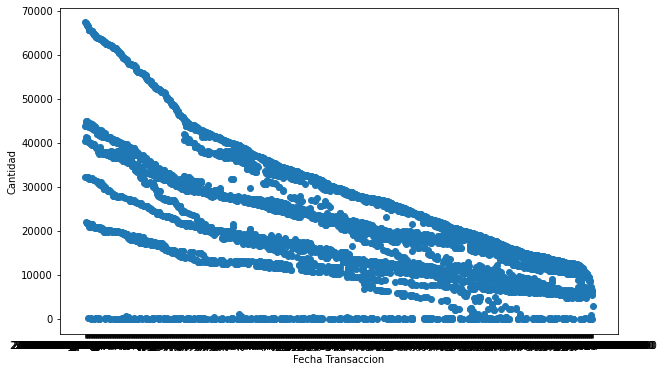

In [90]:
unitPrices = [row['FechaTransaccion'] for row in movimientoscopia.select(col('FechaTransaccion')).collect()]
quantities = [row['Cantidad'] for row in movimientoscopia.collect()]

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(x = unitPrices, y = quantities)
plt.xlabel("Fecha Transaccion")
plt.ylabel("Cantidad")

plt.show()

### Otras opciones de exploración
PySpark también da la opción de crear tablas de pivotes. En el siguiente ejemplo, se muestra cómo hacer una tabla que permite ver cuántas ordenes hay por cada <i>FechaTransaccion</i> y por cada <i>ProveedorID</i>, es decir por fecha y por empleado cuantas ordenes existen:

In [92]:
movimientoscopia.groupBy('FechaTransaccion').pivot('ProveedorID').count().show()

+--------------------+----+----+----+
|    FechaTransaccion| 1.0| 4.0| 7.0|
+--------------------+----+----+----+
|2014-08-28 07:00:...|null|   5|   1|
|2014-09-19 07:00:...|null|   4|   1|
|2014-11-19 07:00:...|null|   6|   3|
|2015-02-18 07:00:...|null|   2|   2|
|2015-10-27 07:00:...|null|   7|   3|
|2016-01-27 07:00:...|null|   4|   4|
|2015-02-12 07:00:...|null|   5|   1|
|2015-01-16 07:00:...|null|   5|   2|
|         Sep 21,2015|null|   2|   1|
|         Oct 14,2014|null|   1|null|
|         Jul 16,2014|null|   4|   1|
|         Mar 25,2015|null|null|   1|
|2014-09-24 07:00:...|null|   2|   4|
|         Jul 18,2014|null|   2|   1|
|         Sep 02,2015|null|   2|   1|
|2014-12-31 07:00:...|null|   4|   3|
|2015-12-17 07:00:...|null|   1|   2|
|2014-11-17 07:00:...|null|   9|   4|
|         Aug 07,2014|null|   3|null|
|         Mar 26,2014|null|   2|   1|
+--------------------+----+----+----+
only showing top 20 rows



Otro análisis muy útil es el de la correlación lineal entre dos variables, para ver la matriz de correlacion que mide esta dependencia o la fuerza de la relación lineal entre dos variables vamos a usar pandas, la interpretación es que si entre dos variables A y B  el valor obtenido es cercano a -1 o a 1, se interpreta como que A y B contienen la misma información y por ende no es necesario mantener ambas columnas

In [93]:
corr = movimientoscopia.toPandas().corr(method='pearson')
corr.style.background_gradient(cmap='coolwarm')

C:\Users\estudiante\anaconda3\envs\Tutoriales\lib\site-packages\pandas\io\formats\style.py:2813: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
C:\Users\estudiante\anaconda3\envs\Tutoriales\lib\site-packages\pandas\io\formats\style.py:2814: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,TransaccionProductoID,ProductoID,TipoTransaccionID,ClienteID,InvoiceID,Cantidad
TransaccionProductoID,1.000000,0.036515,nan,nan,nan,0.623564
ProductoID,0.036515,1.000000,nan,nan,nan,0.121773
TipoTransaccionID,nan,nan,nan,nan,nan,nan
ClienteID,nan,nan,nan,nan,nan,nan
InvoiceID,nan,nan,nan,nan,nan,nan
Cantidad,0.623564,0.121773,nan,nan,nan,1.000000


## Conclusiones/resultados


**Conclusiones generales:**

1. En la tabla de movimientosCopia tenemos información **relacionada con el producto, el tipo de transaccion, el proveedor, el cliente, el identificador de la factura, con la órden, fecha del movimiento en inventario y la cantidad de productos que se retiraron/ingresaron a inventario**. 
2. Una fila de movimientos representa el movimiento que se realiza ya sea por la salida y/o entrada de un prodcto, de la fecha de movimiento, la cantidad, el tipo de transaccion y el numero de la orden de compra.
3. ¿Por que en el campo ClienteID de la tabla movimientosCopia, existen registros con valor 0, siendo que el la tabla Clientes no existe ningun registro con esta identificacion.? 

**Usando herramientas:**

Seccion general del reporte:
1. Tenemos 14 variables y 88.258 registros (es decir, ordenes), de las cuales 7 son numericas, 2 categoricas, 1 booleana, 1 datetime y 3 no soportadas (la herramienta entiende tipo de variable como tipo de dato, asi que la información que nos da no es necesariamente correcta en este aspecto).

2. En los datos hay 29.3% de datos vacíos, (conclusión)

3. El archivo ocupa en memoria 7.5 MB

4. No hay registros duplicados

Sección de variables del reporte:

1. Tenemos 14 variables y 88.258 registros (es decir, ordenes), de las cuales 7 son numericas, 2 categoricas, 1 booleana, 1 datetime y 3 no soportadas (la herramienta entiende tipo de variable como tipo de dato, asi que la información que nos da no es necesariamente correcta en este aspecto).

2. En los datos hay 0.0%% de datos vacíos, (conclusión)

3. El archivo ocupa en memoria 583.4 KiB

4. Esiste un total de 1075, que equivale al 15.1% a regiatros duplicados.

Sección de variables del reporte:

5. Note que para cada variable nos dan estadisticos como la media, mínimo y máximo asi como un histograma de distribución de la variable, para nuestros datos no observamos nada por fuera de lo comun. (Como valores extremos)

6. La variable TransaccionProductoID tiene 84.9% valores distintos, es decir, es una variable con alta cardinalidad. Este tipo de variables no aportan a las relaciones entre filas o columnas, por lo que suelen no ser útiles a la hora de hacer análitica.

7. La variable ProductoID tiene solo el 0.2% de valores distintos, es decir que los movimientos tienen poca salida o entrada de productos, pero que la salida o entrada de estos productos son recurrentes.

8. Hay 3 proveedores en los datos de los movimientos

9. Hay 1256 Fecha de transaccion, siendo el 6 de abril del 2015 una de las fechas con más número de movimientos

 
#### Conclusiones de consultoria
|Tema analitico |analisis requerido o ineridos| Categoria de analisis| Proceso de negocio| Fuente de datos|
|---------------|-----------------------------| ---------------------| ------------------|  --------------|
|Comportamiento de los movimientos|Visualizar la cantidad de movimientos, productos vendidos, el valor total recaudado, cantidad de salidas o entradas |tablero de cntrol  |  ventas |movimientos, clientes, productos, proveedores, TiposTransaccion   |  


Teniendo en cuenta el requerimiento de WWI, consideramos que es posible llevar a cabo una solucióon pues contamos con la información necesaria especificada en el análisis requerido, sin embargo es necesario realizar correcciones a los datos y obtener aclaraciones de parte del negocio para entender completamente la necesidad de negocio